In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import common

common.pltsetup()

In [2]:
def load_distrib(name):
    contents = Path(f'data/forks/{name}.txt').read_text()
    lines = [line.split() for line in contents.splitlines() if line]
    x = [int(v) for v, _ in lines]
    y = [int(v) for _, v in lines]
    return (x, y)

## Forks aggregation process

In [30]:
data = {}

def adapter_import_distrib(entry, pathname):
    data[entry] = {}
    x, y = load_distrib(pathname)
    data[entry]['x'] = x
    data[entry]['y'] = y
    data[entry]['y_cum'] = np.cumsum(y)
    data[entry]['y_cum_inv'] = np.cumsum(y[::-1])[::-1]
    data[entry]['xy'] = np.array(x) * np.array(y)
    data[entry]['xy_cum'] = np.cumsum(data[entry]['xy'])
    data[entry]['xy_cum_inv'] = np.cumsum(data[entry]['xy'][::-1])[::-1]

    
adapter_import_distrib('ghtorrent', 'networks/ghtorrent')
adapter_import_distrib('swh', 'networks/swh_rev')
adapter_import_distrib('swh_rootdir', 'networks/swh_rootdir')
adapter_import_distrib('cliques_partition', 'cliques_partition/swh')
adapter_import_distrib('intersect', 'networks_largest_analysis/intersect')

### Compute WCCDF (Weighted Complementary Cumulative Distribution)

In [36]:
num_origins = sum(data['swh']['xy'])
all_x = np.array(list(sorted(set([val for d in data.values() for val in d['x']]))))

wccdf = {}
for n in data:
    xy_cum_distribution = {
        k: v for k, v in zip(data[n]['x'], data[n]['xy_cum'])
    }
    arr = []
    curr = 0
    for x in all_x:
        curr = xy_cum_distribution.get(x, curr)
        arr.append(curr)
    wccdf[n] = np.array(arr) / num_origins

### Forge - shared-commit networks

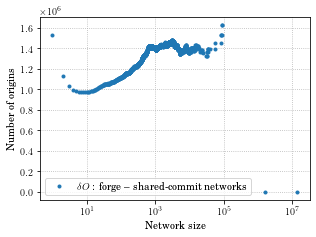

In [32]:
plt.figure(figsize=(4.5, 3.4))
plt.semilogx(
    all_x,
    num_origins * (wccdf['ghtorrent'] - wccdf['swh']),
    ".",
    label="$\\delta O$ : forge -- shared-commit networks",
    rasterized=True
)
plt.xlabel("Network size")
plt.ylabel("Number of origins")
plt.legend()
plt.grid()
plt.savefig("../img/forks/gr/Diff_WCCDF_gh-swhrev.pdf")

### Forge - shared-root-directory forks

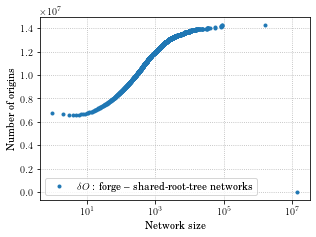

In [33]:
plt.figure(figsize=(4.5, 3.4))
plt.semilogx(
    all_x,
    num_origins * (wccdf['ghtorrent'] - wccdf['swh_rootdir']),
    ".",
    label="$\\delta O$ : forge -- shared-root-tree networks",
    rasterized=True
)
plt.xlabel("Network size")
plt.ylabel("Number of origins")
plt.legend()
plt.grid()
plt.savefig("../img/forks/gr/Diff_WCCDF_gh-swhrootdir.pdf")

### Forge - p-clique forks

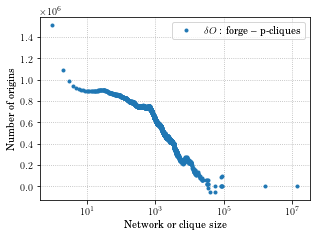

In [34]:
plt.figure(figsize=(4.5, 3.4))
plt.semilogx(
    all_x,
    num_origins * (wccdf['ghtorrent'] - wccdf['cliques_partition']),
    ".",
    label="$\\delta O$ : forge -- p-cliques",
    rasterized=True
)
plt.xlabel("Network or clique size")
plt.ylabel("Number of origins")
plt.legend()
plt.grid()
plt.savefig("../img/forks/gr/Diff_WCCDF_gh-pcliques.pdf")

### Forge - shared-commit networks with WCCDF

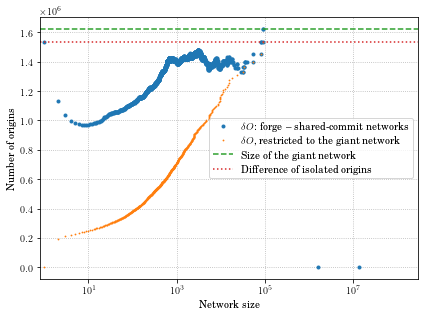

In [35]:
intersect_x = data['intersect']['x']
intersect_cumsum = data['intersect']['xy_cum_inv']

plt.figure(figsize=(6, 4.5))
plt.semilogx(
    all_x,
    num_origins * (wccdf['ghtorrent'] - wccdf['swh']),
    ".",
    label="$\\delta O $: forge -- shared-commit networks",
    rasterized=True
)
plt.semilogx(
    intersect_x,
    (intersect_cumsum[0] - intersect_cumsum),
    ".",
    markersize=1.6,
    label='$\\delta O$, restricted to the giant network',
    rasterized=True
)
plt.semilogx(
    [0.8, 4e8],
    [1624226, 1624226],
    "--",
    label='Size of the giant network'
)
plt.semilogx(
    [0.8,4e8],
    [1533848, 1533848],
    ":",
    label='Difference of isolated origins'
)
plt.xlabel("Network size")
plt.ylabel("Number of origins")
plt.legend()
plt.grid()
plt.xlim([0.8, 3e8])
plt.savefig("../img/forks/gr/Diff_WCCDF_all.pdf")